# Importing Libraries 

In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import csv
from sklearn.feature_extraction.text import CountVectorizer,  TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier 
import nltk
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Load DataSet

In [2]:
train_df = pd.read_csv("train.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


## Dataset Properties 

In [5]:
train_df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [6]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
X = train_df.drop(["id"],axis=1)
X.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
print(train_df["id"].nunique())
print(train_df["keyword"].nunique())
print(train_df["location"].nunique())
print(train_df["target"].unique())
print(train_df["text"].nunique())

7613
221
3341
[1 0]
7503


## Data PreProcessing 

### Filling Missing Value with Most Frequent Value

In [10]:
key = X["keyword"].value_counts().index[0]
print("most frequent word in keyword is :",key)
loc = X["location"].value_counts().index[0]
print("most frequent word in location is :",loc)

most frequent word in keyword is : fatalities
most frequent word in location is : USA


In [11]:
train_df['keyword'] = train_df['keyword'].fillna(train_df['keyword'].value_counts().idxmax())

In [12]:
train_df['location'] = train_df['location'].fillna(train_df['location'].value_counts().idxmax())

In [13]:
train_df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [14]:
train_df.head()

,id,keyword,location,text,target
0,1,fatalities,USA,Our Deeds are the Reason of this #earthquake M...,1
1,4,fatalities,USA,Forest fire near La Ronge Sask. Canada,1
2,5,fatalities,USA,All residents asked to 'shelter in place' are ...,1
3,6,fatalities,USA,"13,000 people receive #wildfires evacuation or...",1
4,7,fatalities,USA,Just got sent this photo from Ruby #Alaska as ...,1


In [15]:
X_new = train_df.drop(["target"],axis=1)
X_new.head()

,id,keyword,location,text
0,1,fatalities,USA,Our Deeds are the Reason of this #earthquake M...
1,4,fatalities,USA,Forest fire near La Ronge Sask. Canada
2,5,fatalities,USA,All residents asked to 'shelter in place' are ...
3,6,fatalities,USA,"13,000 people receive #wildfires evacuation or..."
4,7,fatalities,USA,Just got sent this photo from Ruby #Alaska as ...


In [16]:
y = train_df["target"]
y.shape

(7613,)

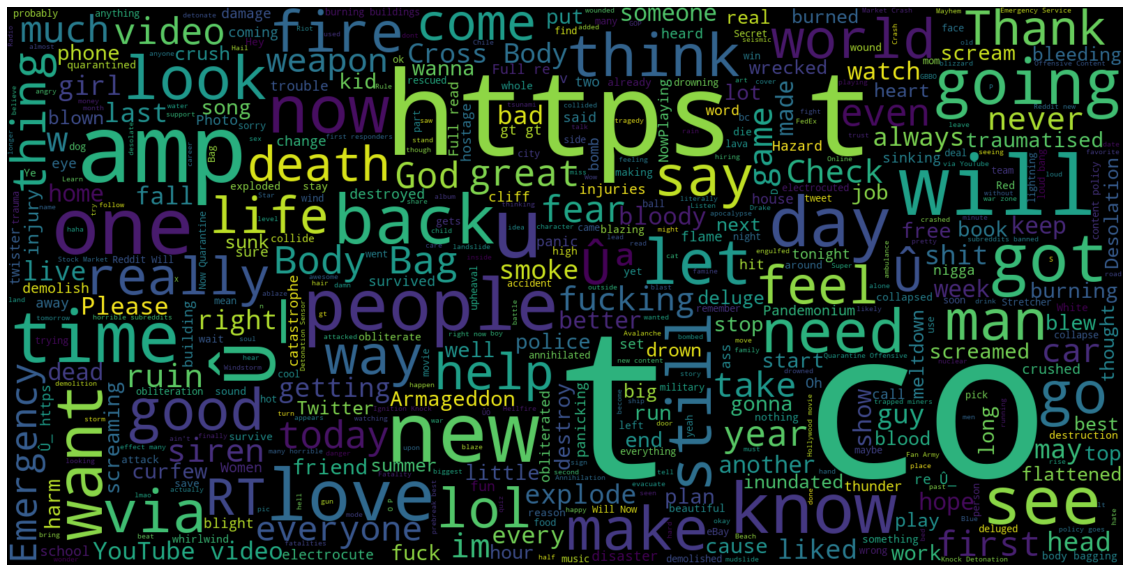

In [17]:
#not a disaster tweet
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(train_df[train_df.target == 0].text))
plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

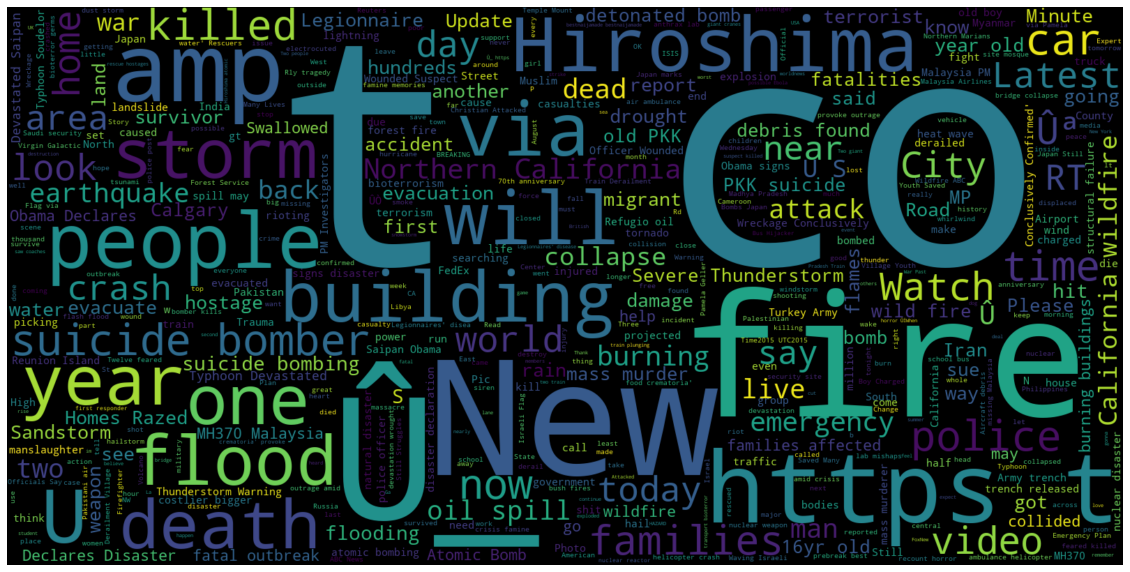

In [18]:
# Disaster Tweet
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(train_df[train_df.target == 1].text))
plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

## Test Data PreProcessing 

In [19]:
test_df.head(2)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."


### Handel Missing Value 

In [20]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [21]:
test_df['keyword'] = test_df['keyword'].fillna(test_df['keyword'].value_counts().idxmax())

In [22]:
test_df['location'] = test_df['location'].fillna(test_df['location'].value_counts().idxmax())

In [23]:
test_df.shape

(3263, 4)

In [24]:
test_df.head()

,id,keyword,location,text
0,0,deluged,New York,Just happened a terrible car crash
1,2,deluged,New York,"Heard about #earthquake is different cities, s..."
2,3,deluged,New York,"there is a forest fire at spot pond, geese are..."
3,9,deluged,New York,Apocalypse lighting. #Spokane #wildfires
4,11,deluged,New York,Typhoon Soudelor kills 28 in China and Taiwan


## Text PreProcessing 

### Removing extra punctuations like , ? / @ # ! * ~ etc all

In [25]:
X_new.replace("[^a-zA-Z]", " ",regex = True, inplace = True)
X_new.head()

,id,keyword,location,text
0,1,fatalities,USA,Our Deeds are the Reason of this earthquake M...
1,4,fatalities,USA,Forest fire near La Ronge Sask Canada
2,5,fatalities,USA,All residents asked to shelter in place are ...
3,6,fatalities,USA,people receive wildfires evacuation or...
4,7,fatalities,USA,Just got sent this photo from Ruby Alaska as ...


### Converting Upper case to Lower case so all string data are same

In [26]:
X_new = X_new.drop(["id"],axis=1)
X_new.head()

,keyword,location,text
0,fatalities,USA,Our Deeds are the Reason of this earthquake M...
1,fatalities,USA,Forest fire near La Ronge Sask Canada
2,fatalities,USA,All residents asked to shelter in place are ...
3,fatalities,USA,people receive wildfires evacuation or...
4,fatalities,USA,Just got sent this photo from Ruby Alaska as ...


In [27]:
# Converting into lower case
for i in X_new.columns:
    X_new[i] = X_new[i].str.lower()
X_new.head(1)

,keyword,location,text
0,fatalities,usa,our deeds are the reason of this earthquake m...


### Remove StopWords

In [28]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [29]:
X_new['keyword'].apply(lambda x: [item for item in x if item not in stop])
X_new['location'].apply(lambda x: [item for item in x if item not in stop])
X_new['text'].apply(lambda x: [item for item in x if item not in stop])
print(X_new.shape)

(7613, 3)


## Text PreProcessing in Test Data 

In [30]:
ori_test = test_df.drop(["id"],axis=1)

In [31]:
# Removing extra punctuations like , ? / @ # ! * ~ etc all
ori_test.replace("[^a-zA-Z]", " ",regex = True, inplace = True)
ori_test.head()

,keyword,location,text
0,deluged,New York,Just happened a terrible car crash
1,deluged,New York,Heard about earthquake is different cities s...
2,deluged,New York,there is a forest fire at spot pond geese are...
3,deluged,New York,Apocalypse lighting Spokane wildfires
4,deluged,New York,Typhoon Soudelor kills in China and Taiwan


In [32]:
# Converting Upper case to Lower case so all string data are same
for i in ori_test.columns:
    ori_test[i] = ori_test[i].str.lower()
ori_test.head()

,keyword,location,text
0,deluged,new york,just happened a terrible car crash
1,deluged,new york,heard about earthquake is different cities s...
2,deluged,new york,there is a forest fire at spot pond geese are...
3,deluged,new york,apocalypse lighting spokane wildfires
4,deluged,new york,typhoon soudelor kills in china and taiwan


In [33]:
# Remove StopWords
ori_test['keyword'].apply(lambda x: [item for item in x if item not in stop])
ori_test['location'].apply(lambda x: [item for item in x if item not in stop])
ori_test['text'].apply(lambda x: [item for item in x if item not in stop])
print(ori_test.shape)

(3263, 3)


## Splitting data 

In [34]:
# Adding Keyword and Text because both are important for our prediction 

# IN TRAIN DATASET
X_new["sentence"] = X_new['keyword'] + " " + X_new['text']
train_text = np.array(X_new["sentence"])
print(train_text[0])
print(f" train_text type : '{type(train_text)}' ")

# IN TEST DATASET 
ori_test["sentence"] = ori_test['keyword'] + " " + ori_test['text']
test_text = np.array(ori_test["sentence"])
print(test_text[0])

fatalities our deeds are the reason of this  earthquake may allah forgive us all
 train_text type : '<class 'numpy.ndarray'>' 
deluged just happened a terrible car crash


In [35]:
print(train_text[0])

fatalities our deeds are the reason of this  earthquake may allah forgive us all


In [36]:
test_text[0]

'deluged just happened a terrible car crash'

In [37]:
from wordcloud import WordCloud

In [38]:
x_train, x_test, y_train, y_test = train_test_split(train_text,y,test_size=0.25,random_state=0)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5709,)
(1904,)
(5709,)
(1904,)


## CountVectorizer change text to vector and help to use BagOfWords

In [39]:
# encoding essay attribute using count vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(x_train)

keyword = vectorizer.get_feature_names()
X_train = vectorizer.transform(x_train)
X_test = vectorizer.transform(x_test)
X_test_new = vectorizer.transform(test_text)

print(" after encoding in bow the size of keyword:",len(keyword))
print(" train feature --",X_train.shape,y_train.shape)
print("test feature --",X_test.shape,y_test.shape)
print("new test feature --",X_test_new.shape)

 after encoding in bow the size of keyword: 18272
 train feature -- (5709, 18272) (5709,)
test feature -- (1904, 18272) (1904,)
new test feature -- (3263, 18272)


In [40]:
print("data before vectorization :\n",x_train[0])
print("\n")
print("data after vectorization in vector form : \n",X_train[0])

data before vectorization :
 oil   spill refugio oil spill may have been costlier bigger than projected  a plains all american pipeline oil spill off     http   t co yhmregauxz


data after vectorization in vector form : 
   (0, 17861)	0.2565668314084014
  (0, 15442)	0.14366087248498907
  (0, 14571)	0.5237386817894252
  (0, 12885)	0.19060966227864334
  (0, 12192)	0.1892120760961464
  (0, 11828)	0.22068164338909357
  (0, 11771)	0.22509726411545425
  (0, 11041)	0.5122637278245114
  (0, 10986)	0.14658635497872421
  (0, 9579)	0.15431815773620025
  (0, 7032)	0.04966717003573883
  (0, 6568)	0.11481042289808198
  (0, 3018)	0.19060966227864334
  (0, 2699)	0.04697600409067743
  (0, 1419)	0.1892120760961464
  (0, 1261)	0.1363386758557607
  (0, 472)	0.18787951794292748
  (0, 392)	0.1270409455452105


## Predict

In [41]:
rc = RandomForestClassifier(max_depth = 400 ,random_state=0, n_estimators = 300)
rc.fit(X_train,y_train) # fit in model

pred1 = rc.predict(X_test) # predict data 

In [42]:
# Metric
matrix = confusion_matrix(y_test,pred1)
print(matrix)
score = accuracy_score(y_test,pred1)
print(score)
report = classification_report(y_test,pred1)
print(report)
prediction1 = rc.predict(X_test_new)
prediction1

[[1018   89]
 [ 321  476]]
0.7846638655462185
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1107
           1       0.84      0.60      0.70       797

    accuracy                           0.78      1904
   macro avg       0.80      0.76      0.77      1904
weighted avg       0.79      0.78      0.78      1904



array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

## Save Result 

In [43]:
data = {'id':test_df["id"],'target':prediction1}
output = pd.DataFrame(data, columns = ['id','target'])
output.index = test_df.index

output.to_csv("result.csv", index = False)    

# the csv file will be saved locally on the same location where this notebook is located.
a = pd.read_csv("result.csv")
a

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,0
